In [1]:
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt 
import nilearn.plotting as niplt
%matplotlib inline
import os

In [5]:
black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-292', 'sub-311', 'sub-267', 'sub-295', 
'sub-305', 'sub-274', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
 'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-296', 'sub-127', 'sub-279', 
 'sub-315', 'sub-314']
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']

rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG']
roi_names=['L_'+roi for roi in rois]+['R_'+roi for roi in rois] 
def get_result_dataset(dataset,rep_name):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        if 'layer' not in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+story+"_"+rep_name+"/"
        else:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            results_sub=np.zeros((12,))
            for roi in range(12):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
            results_story.append(results_sub)
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    return np.concatenate(results,axis=0)
            

def bootstrap_errors(data):
    mean=data.mean()
    sampling=[]
    for _ in range(10000):
        sampling.append(np.mean(np.random.choice(data,size=len(data),replace=True)))
    sampling=np.asarray(sampling)
    ci=np.percentile(sampling,[2.5,97.5])
    return np.abs(ci-mean)

def barplot(dataset,rep_names):
    barWidth=0.8/len(rep_names)
    for r_idx,rep_name in enumerate(rep_names):
        results=get_result_dataset(dataset,rep_name)
        errors=np.asarray([bootstrap_errors(results[:,i]) for i in range(results.shape[1])])
        plt.bar([i+(r_idx*barWidth) for i in range(12)],results.mean(axis=0),yerr=errors.T,width=barWidth)
    if 'layer' not in rep_names[0]:
        plt.legend([r[18:] for r in rep_names])
    else:
        plt.legend(rep_names)
    plt.xticks(list(range(12)),roi_names,rotation=90)
    if len(dataset)==2:
        story_name='Combined Storys'
    else:
        story_name=dataset[0]
    plt.title(story_name)
    plt.ylabel("Pearson's R")
    plt.ylim(-0.02,0.08)


In [6]:
fnames=os.listdir('/jukebox/griffiths/bert-brains/code/bert-brains/data/black/bert-base-uncased/syntactic_analyses/')
dataset=['black','slumlordreach']
reps=[rep[6:-4] for rep in fnames]
reps 

['bert-base-uncased_semantic_composition_20-TRs',
 'bert-base-uncased_semantic_composition_0-TRs',
 'bert-base-uncased_syntactic_complexity_L-inf_T-20_D-concat',
 'bert-base-uncased_semantic_composition_1-TRs',
 'bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat',
 'bert-base-uncased_syntactic_distance_T-128_D-bck',
 'bert-base-uncased_syntactic_complexity_L-inf_T-10_D-bck',
 'bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat',
 'bert-base-uncased_semantic_composition_5-TRs',
 'bert-base-uncased_syntactic_complexity_L-1_T-20_D-fwd',
 'bert-base-uncased_syntactic_distance_T-10_D-fwd',
 'bert-base-uncased_syntactic_complexity_L-inf_T-20_D-bck',
 'bert-base-uncased_syntactic_complexity_L-1_T-128_D-fwd',
 'bert-base-uncased_syntactic_complexity_L-1_T-10_D-concat',
 'bert-base-uncased_semantic_composition_2-TRs',
 'bert-base-uncased_semantic_composition_10-TRs',
 'bert-base-uncased_syntactic_distance_T-128_D-concat',
 'bert-base-uncased_syntactic_complexity_L-1_T-10_D-fwd',

Text(0.5, 1.0, 'Directionality')

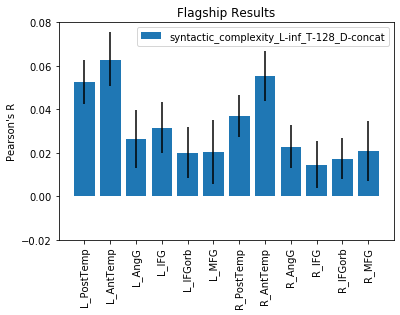

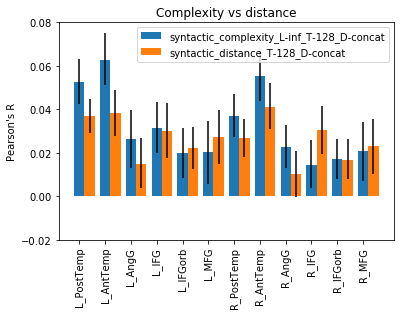

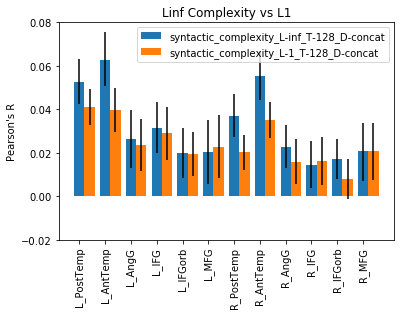

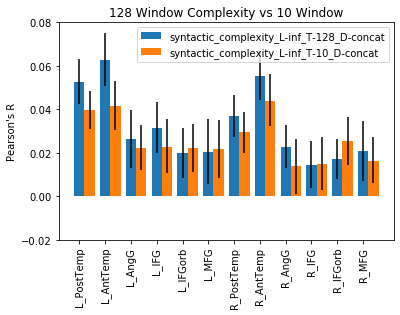

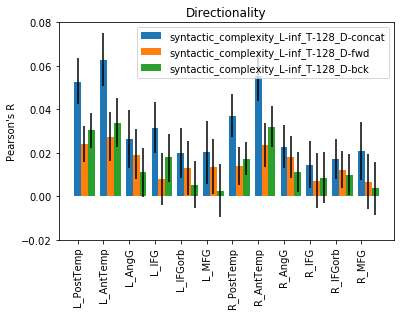

In [7]:
barplot(dataset,['bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat'])
plt.title("Flagship Results")
plt.figure()
barplot(dataset,['bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat','bert-base-uncased_syntactic_distance_T-128_D-concat'])
plt.title("Complexity vs distance")
plt.figure()
barplot(dataset,['bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat','bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat'])
plt.title("Linf Complexity vs L1")
plt.figure()
barplot(dataset,['bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat','bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat'])
plt.title("128 Window Complexity vs 10 Window")
plt.figure()
barplot(dataset,['bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat','bert-base-uncased_syntactic_complexity_L-inf_T-128_D-fwd','bert-base-uncased_syntactic_complexity_L-inf_T-128_D-bck'])
plt.title("Directionality")

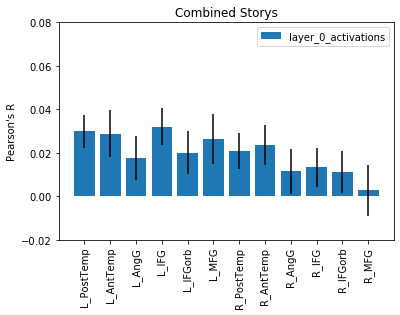

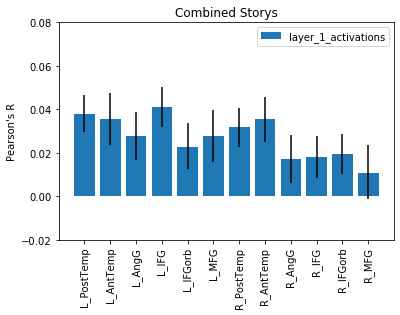

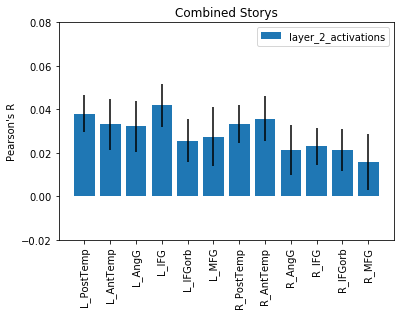

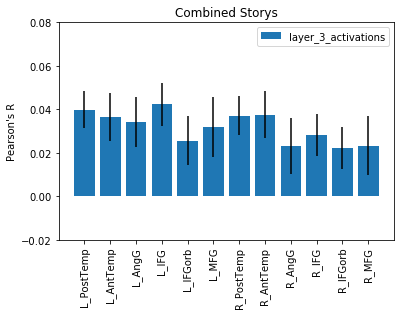

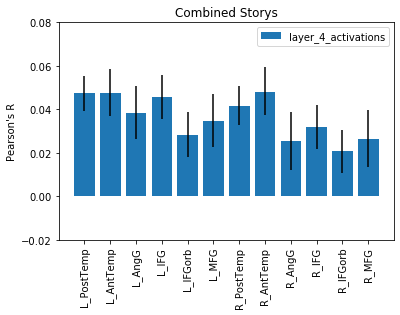

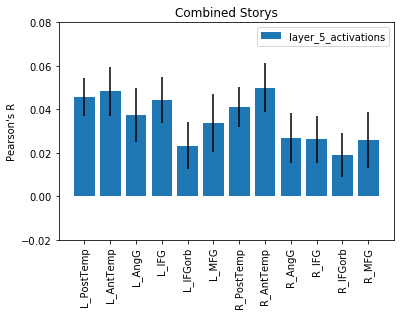

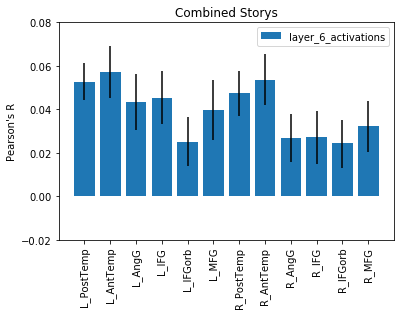

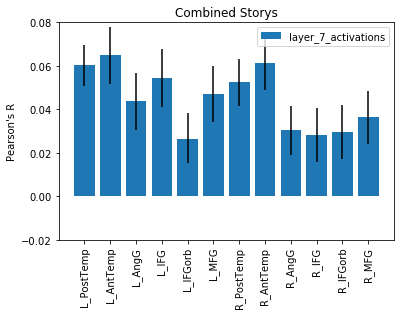

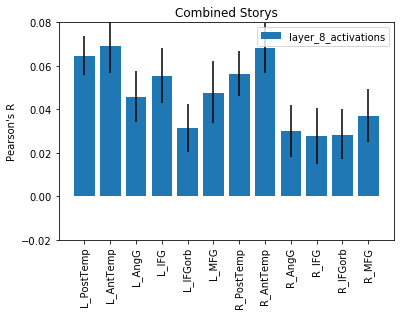

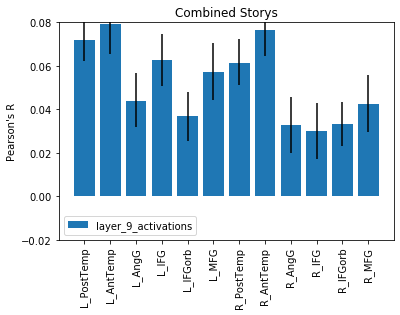

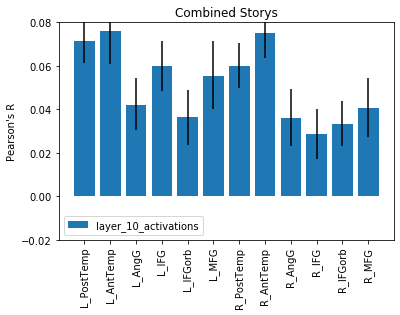

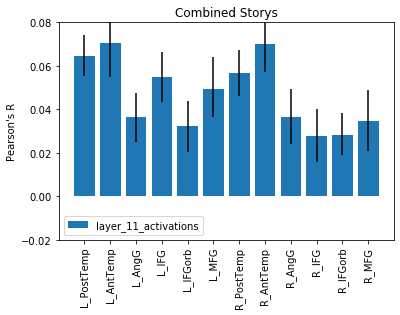

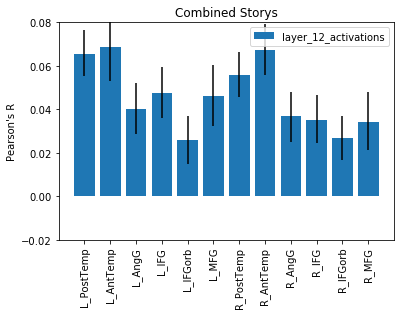

In [8]:
for i in range(13):
    plt.figure()
    barplot(dataset,['layer_'+str(i)+"_activations"])

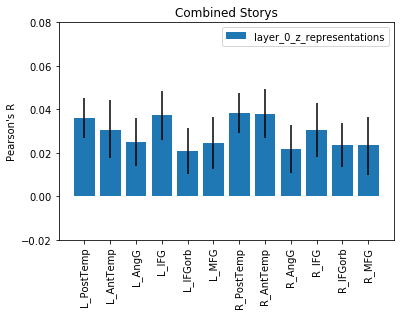

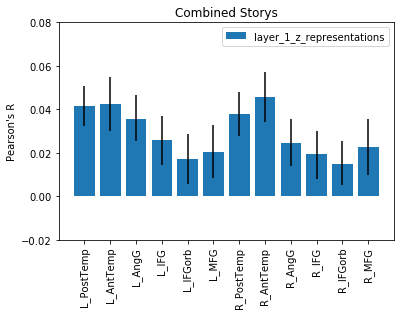

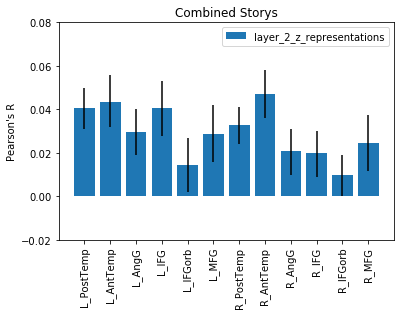

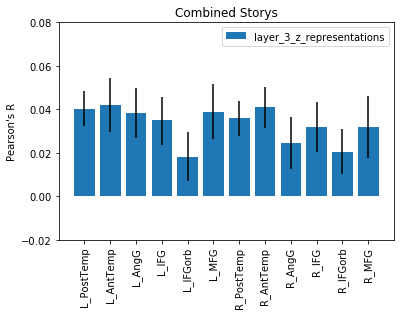

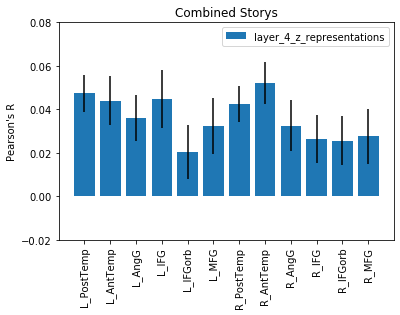

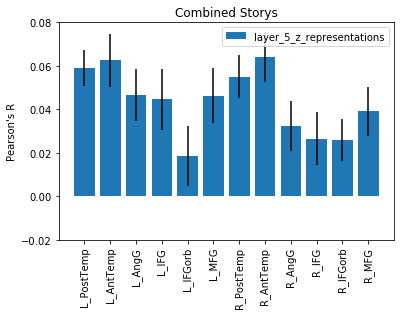

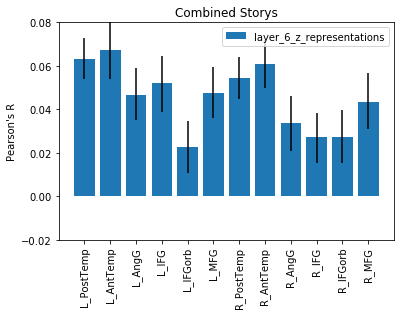

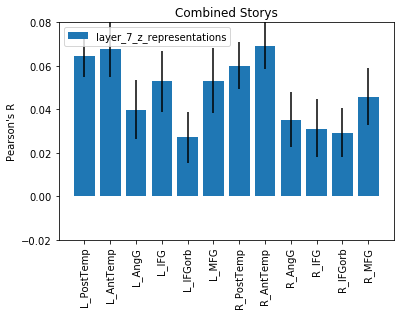

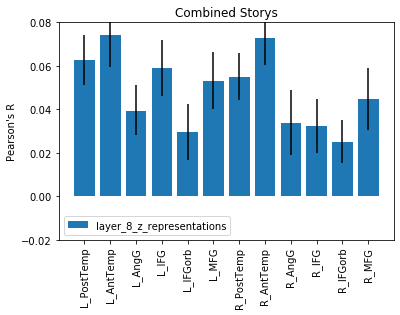

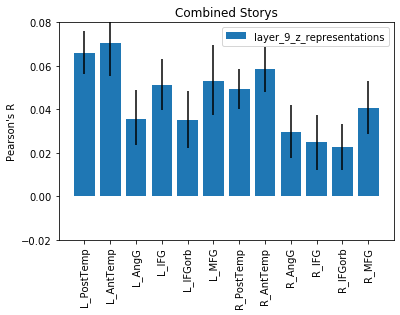

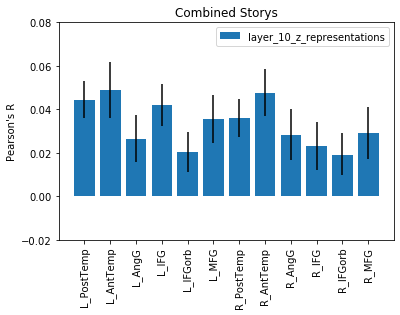

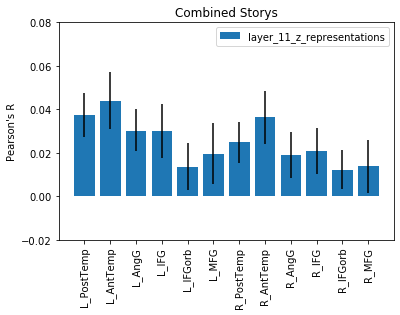

In [9]:
dataset=['black','slumlordreach']
for i in range(12):
    plt.figure()
    barplot(dataset,['layer_'+str(i)+"_z_representations"])